In [1]:
import json
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
import os
from tqdm import tqdm
from scipy.optimize import fsolve

In [ ]:
def model_size_from_filename(filename):
    return int(filename.split('B')[0].split('-')[-1])

def alpha_from_filename(filename):
    return float(filename.split('alpha-')[-1].split('_')[0])

def draft_from_filename(filename):
    return int(filename.split('draft-')[-1].split('_')[0])

def prompt_length_from_filename(filename):
    return int(filename.split('prompt-')[-1].split('_')[0])

def output_length_from_filename(filename):
    return int(filename.split('output-')[-1].split('_')[0])

In [ ]:
def expected_acceptance_length(alpha, draft):
    if alpha == 1.0:
        return draft + 1
    else:
        return (1. - alpha ** (draft + 1)) / (1. - alpha)

In [ ]:
def getTTFT(filename):
    with open(filename, 'r') as file:
        data = json.load(file)
    itl=[]
    rps=[]
    # print(data['benchmarks'][0]['metrics'].keys())
    for i in range(len(data)):
        # print(data['benchmarks'][i]['metrics'].keys())
        itl.append(data[i]['time_to_first_token_ms']['successful']['mean'])
        rps.append((data[i]['requests_per_second']['successful']['mean']))
    itl, rps=np.array(itl), np.array(rps)
    # print(itl)
    # print(rps)
    indx=np.argsort(rps)

    return  rps[indx],itl[indx]

def getITL(filename):
    with open(filename, 'r') as file:
        data = json.load(file)
    itl=[]
    rps=[]
    # print(data['benchmarks'][0]['metrics'].keys())
    for i in range(len(data)):
        # print(data['benchmarks'][i]['metrics'].keys())
        itl.append(data[i]['inter_token_latency_ms']['successful']['mean'])
        #rps.append((data[i]['requests_per_second']['successful']['mean']))
        rps.append((data[i]['requests_per_second']['successful']['mean']))
    # print(itl)
    # print(rps)
    indx=np.argsort(rps)
    itl = itl[indx]
    rps = rps[indx]

    return  rps,itl

def getRequestLatency(filename):
    with open(filename, 'r') as file:
        data = json.load(file)
    itl=[]
    rps=[]

    # print(data['benchmarks'][0]['metrics'].keys())
    for i in range(len(data)):
        # print(data['benchmarks'][i]['metrics']['request_latency']['successful'].keys())
        itl.append(data[i]['request_latency']['successful']['mean'] * 1000)
        rps.append((data[i]['requests_per_second']['successful']['mean']))
    itl, rps=np.array(itl), np.array(rps)
    indx=np.argsort(rps)
    itl = itl[indx]
    rps = rps[indx]
    itl = itl[:-3]
    rps = rps[:-3]
    return  rps, itl

def getTPOT(filename):
    with open(filename, 'r') as file:
        data = json.load(file)
    itl=[]
    rps=[]
    # print(data['benchmarks'][0]['metrics'].keys())
    for i in range(len(data)):
        # print(data['benchmarks'][i]['metrics'].keys())
        itl.append(data[i]['time_per_output_token_ms']['successful']['mean'])
        rps.append((data[i]['requests_per_second']['successful']['mean']))
    itl, rps=np.array(itl), np.array(rps)
    # print(itl)
    # print(rps)
    indx=np.argsort(rps)

    return  rps[indx],itl[indx]


In [38]:
def fit_ITL_from_RPS(rps, lat, Et, k, label=None, debug=False):
    def model(x, b1 , b2, c1, c2, d1, d2, f1, f2):
        return (b1 + b2*k + (c1 + c2*k)/Et) / (1 - (d1 + d2*k + (f1 + f2*k)/Et) * x)
    def fit_model(x, b1, b2, c1, c2, d1, d2, f1, f2):
        rps, lat = x
        return model(rps, b1, b2, c1, c2, d1, d2, f1, f2) / lat
    A = np.vstack([np.ones_like(rps)/lat, k/lat, np.ones_like(rps)/Et/lat, k/Et/lat, rps, rps*k, rps/Et, rps*k/Et]).T
    z = np.ones_like(rps)
    b1_0, b2_0, c1_0, c2_0, d1_0, d2_0, f1_0, f2_0 = np.linalg.lstsq(A, z, rcond=None)[0]   # z ≈ a + b x
    #popt, pcov = curve_fit(model, baseline_rps, baseline_itl, p0=[c1_0, c2_0], maxfev=10000)
    popt, pcov = curve_fit(fit_model, (rps, lat), np.ones_like(rps), p0=[b1_0, b2_0, c1_0, c2_0, d1_0, d2_0, f1_0, f2_0], maxfev=10000)
    #popt = [b1_0, b2_0, c1_0, c2_0, d1_0, d2_0, f1_0, f2_0]
    #popt = [c1_0, c2_0, d1_0, d2_0, f1_0, f2_0]
    # plt plot the data and fit and return the fit parameters
    if debug:
        plt.scatter(rps, lat, label='Request Latency', color='blue')
        plt.xlabel("RPS")
        plt.ylabel("Latency")
        if label is not None:
            plt.title(f"Modeled vs Measured Latency, {label}")
        else:
            plt.title("Modeled vs Measured Latency")
        plt.plot(rps, model(rps, *popt), label='Modeled Latency', color='red')
        plt.legend()

        # Add the popt parameters to the plot in the form of the formula
        plt.text(0.05, 0.95, f'ITL = {popt[0]:.2f} / (1 - {popt[1]:.2f} * RPS)', 
                transform=plt.gca().transAxes, verticalalignment='top',
                color='black')
        
        plt.show()
    return popt

### Formulation: Lat = TTFT + G * ITL
TTFT = B * (d1 + d2*k)
ITL = (c1 + c2*k + (f1 + f2*k) * B)/E
Lat = B * (d1 + d2*k + G * (f1 + f2*k)/E) + G * (c1 + c2*k)/E
B = RPS * Lat
Lat = (c1 + c2*k)/E / (1 - (d1 + d2*k + (f1 + f2*k)/E)*)


In [7]:
model_sizes = ["0.6B", "1.7B", "4B", "8B", "14B", "32B"]
alphas = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
drafts = [1, 2, 3, 4, 5, 6, 8, 10]
parameters = {0:0.76, 1:2, 2:4.4, 3:8, 4:14, 5:32}
drafter_parameters = {0:0.205, 1:0.214, 2:0.58, 3:1, 4:1.3, 5:1.48}
h = {0:1024, 1:2048, 2:2560, 3:4096, 4:5120, 5:5120}
nlayers = {0:28, 1:28, 2:36, 3:36, 4:40, 5:64}

In [8]:
DATA_DIR = "."


  0%|          | 0/6 [00:00<?, ?it/s]

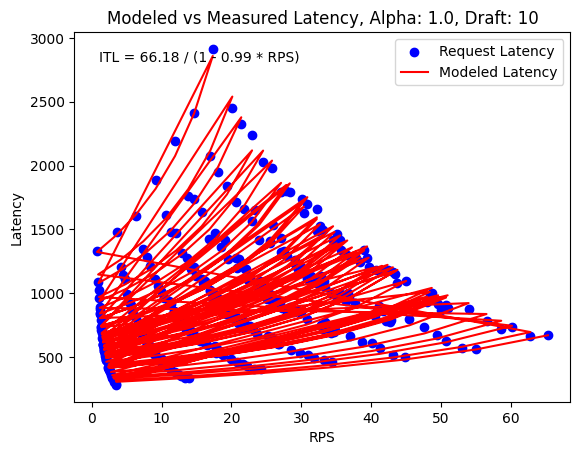

 17%|█▋        | 1/6 [00:00<00:00,  6.99it/s]

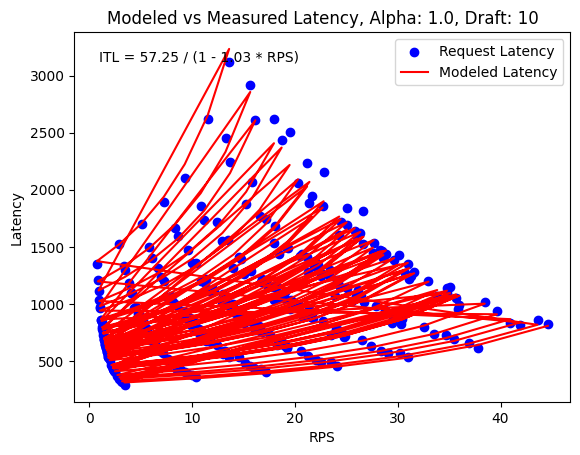

 33%|███▎      | 2/6 [00:00<00:00,  7.42it/s]

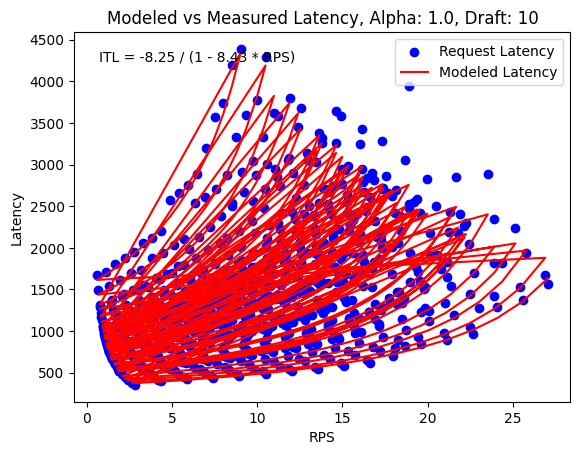

 50%|█████     | 3/6 [00:00<00:00,  5.42it/s]

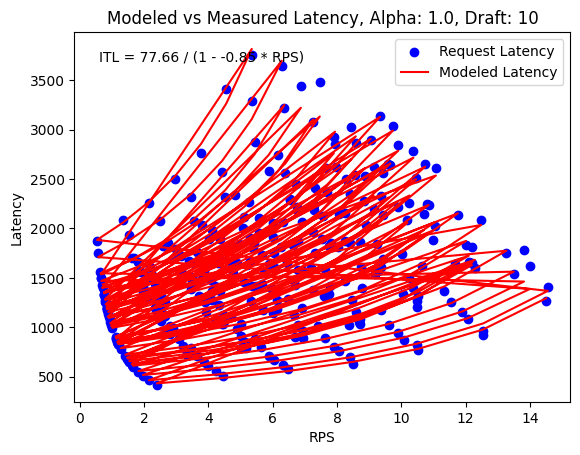

 67%|██████▋   | 4/6 [00:00<00:00,  6.07it/s]

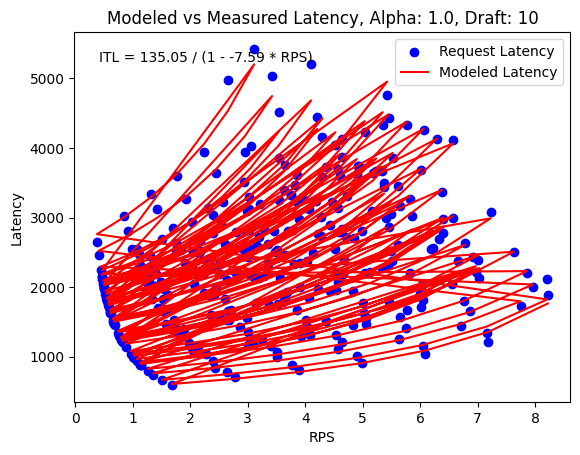

 83%|████████▎ | 5/6 [00:00<00:00,  6.62it/s]

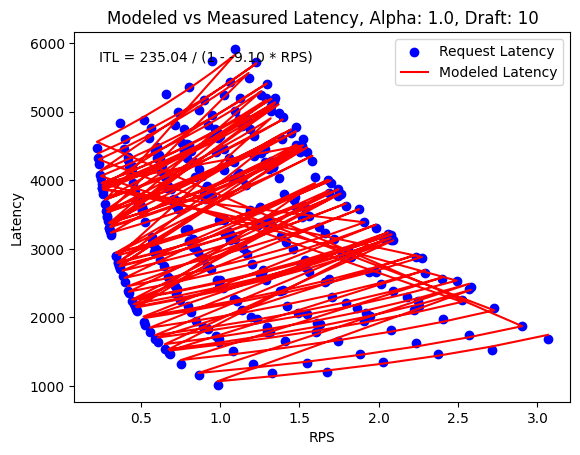

100%|██████████| 6/6 [00:00<00:00,  6.63it/s]

[66.17597136695524, 57.2450905172335, -8.253806347422325, 77.66146004407727, 135.05071856860212, 235.03658153460046]
[0.9947855952815093, 1.0284027955198713, 8.42872704826235, -0.8504936007333782, -7.589348239516906, -9.099226880505306]
[688.3716253738842, 822.9526040606701, 1389.8456151802714, 1779.3808420380083, 2672.5708143580046, 5645.004494530586]
[174.37776954912735, 170.1937179821043, 154.9288902259987, 164.92643003567937, 239.44429832945468, 270.1347181556915]
[0.004131034498905712, 0.006847012233656568, 0.023650596798680798, 0.030798068961464583, 0.047304549698074336, 0.11262902514901968]
[-7.241242894995765e-05, 8.7334526590075e-05, -0.0003803507604854837, 0.0006533687984814239, 0.0021796377289920316, 0.0027133708806484132]
[0.016708696741800026, 0.01914155533669708, 0.02154612394329164, 0.03396405839859167, 0.0759896183361483, 0.15131480896184468]
[0.003965799679874405, 0.005191662226899432, 0.008136013913351876, 0.009054047142340448, 0.01079583527741133, 0.00432343022213877

In [ ]:
Qwen_b1 = []
Qwen_b2 = []
Qwen_c1 = []
Qwen_c2 = []
Qwen_d1 = []
Qwen_d2 = []
Qwen_f1 = []
Qwen_f2 = []
for model_size in tqdm(model_sizes):
    rps = None
    lat = None
    Et = None
    k = None
    for j, draft in enumerate(drafts):
        for i, alpha in enumerate(alphas):
            path = f"{DATA_DIR}/output_Qwen3-{model_size}_FS_alpha-{alpha:.2f}_draft-{draft}_prompt-512_output-128_concurrency-128_reduced.json"
            rps_, lat_ = getRequestLatency(path)
            Et_ = expected_acceptance_length(alpha, draft)
            Et_ = np.ones_like(rps_) * Et_
            k_ = np.ones_like(rps_) * draft
            if rps is None:
                rps = rps_
                lat = lat_
                Et = Et_
                k = k_
            else:
                rps = np.concatenate((rps, rps_))
                lat = np.concatenate((lat, lat_))
                Et = np.concatenate((Et, Et_))
                k = np.concatenate((k, k_))

    fit = fit_ITL_from_RPS(rps, lat, Et, k, f"Alpha: {alpha}, Draft: {draft}", debug=True)
    Qwen_b1.append(fit[0].item())
    Qwen_b2.append(fit[1].item())
    Qwen_c1.append(fit[2].item())
    Qwen_c2.append(fit[3].item())
    Qwen_d1.append(fit[4].item())
    Qwen_d2.append(fit[5].item())
    Qwen_f1.append(fit[6].item())
    Qwen_f2.append(fit[7].item())
print(Qwen_b1)
print(Qwen_b2)
print(Qwen_c1)
print(Qwen_c2)
print(Qwen_d1)
print(Qwen_d2)
print(Qwen_f1)
print(Qwen_f2)
    

/var/folders/4c/rx0z8dkn0d76h53p7048t57m0000gn/T/ipykernel_22945/708113408.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


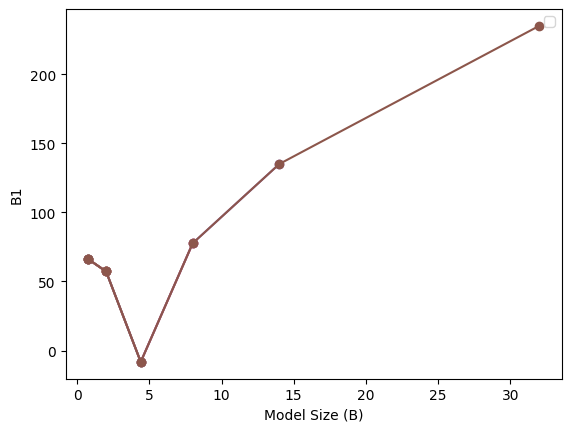

[ 6.462473   27.94519451]


In [24]:
x_vals = []
y_vals = []
for size in range(len(model_sizes)):
    x_vals.append(parameters[size])
    y_vals.append(Qwen_b1[size])
    plt.plot(x_vals, y_vals, marker="o")
plt.legend() 
plt.xlabel("Model Size (B)")
plt.ylabel("B1") 
plt.show()

p = np.polyfit(x_vals, y_vals, 1)
print(p)


/var/folders/4c/rx0z8dkn0d76h53p7048t57m0000gn/T/ipykernel_22945/459175275.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


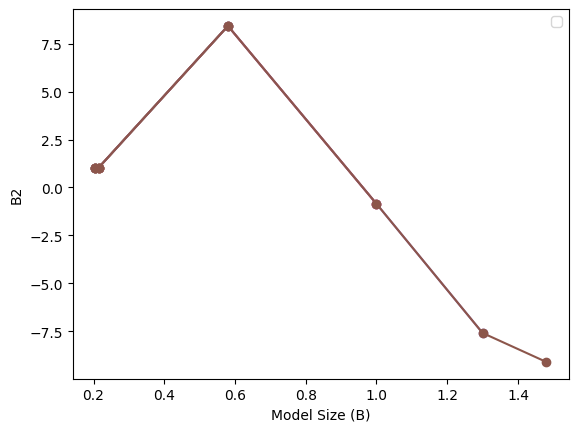

[-8.82817852  5.85045197]


In [23]:
x_vals = []
y_vals = []
for size in range(len(model_sizes)):
    x_vals.append(drafter_parameters[size])
    y_vals.append(Qwen_b2[size])
    plt.plot(x_vals, y_vals, marker="o")
plt.legend() 
plt.xlabel("Model Size (B)")
plt.ylabel("B2") 
plt.show()

p = np.polyfit(x_vals, y_vals, 1)
print(p)

/var/folders/4c/rx0z8dkn0d76h53p7048t57m0000gn/T/ipykernel_22945/282775360.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


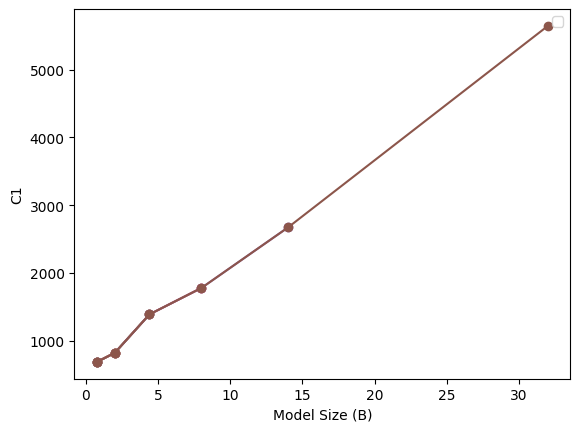

[157.89515568 556.87637903]


In [25]:
x_vals = []
y_vals = []
for size in range(len(model_sizes)):
    x_vals.append(parameters[size])
    y_vals.append(Qwen_c1[size])
    plt.plot(x_vals, y_vals, marker="o")
plt.legend() 
plt.xlabel("Model Size (B)")
plt.ylabel("C1") 
plt.show()

p = np.polyfit(x_vals, y_vals, 1)
print(p)


/var/folders/4c/rx0z8dkn0d76h53p7048t57m0000gn/T/ipykernel_22945/3440352965.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


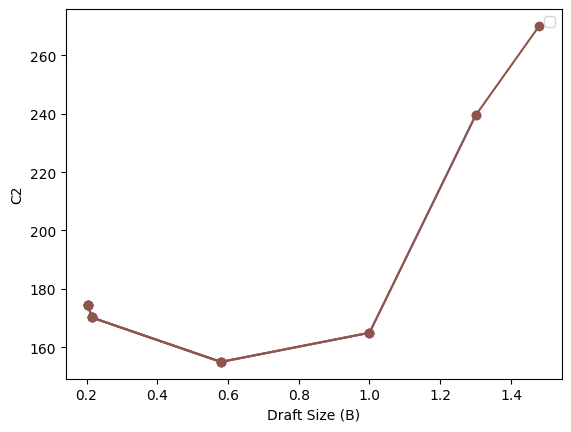

[ 160.08688817 -190.65258419  205.98904255]


In [39]:
x_vals = []
y_vals = []
for size in range(len(model_sizes)):
    x_vals.append(drafter_parameters[size])
    y_vals.append(Qwen_c2[size])
    plt.plot(x_vals, y_vals, marker="o")
plt.legend() 
plt.xlabel("Draft Size (B)")
plt.ylabel("C2") 
plt.show()

p = np.polyfit(x_vals, y_vals, 2)
print(p)


/var/folders/4c/rx0z8dkn0d76h53p7048t57m0000gn/T/ipykernel_22945/530998650.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


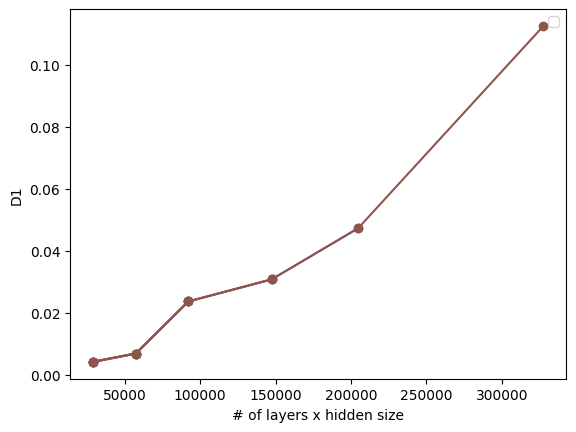

[7.81174029e-13 7.61084157e-08 2.76281674e-03]


In [45]:
x_vals = []
y_vals = []
for size in range(len(model_sizes)):
    x_vals.append(nlayers[size]*h[size])
    y_vals.append(Qwen_d1[size])
    plt.plot(x_vals, y_vals, marker="o")
plt.legend() 
plt.xlabel("# of layers x hidden size")
plt.ylabel("D1") 
plt.show()

p = np.polyfit(x_vals, y_vals, 2)
print(p)

/var/folders/4c/rx0z8dkn0d76h53p7048t57m0000gn/T/ipykernel_22945/508444234.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


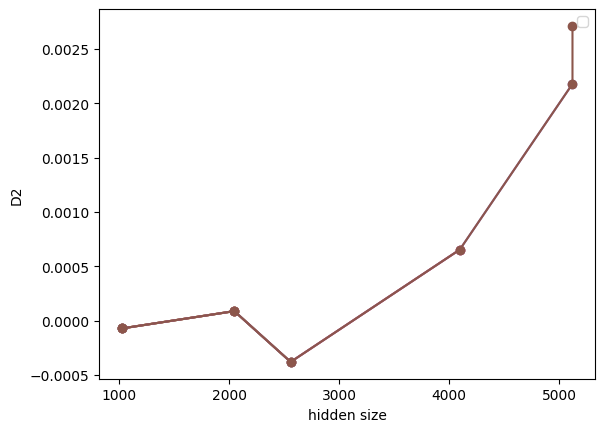

[ 3.01527869e-10 -1.28753160e-06  1.07764495e-03]


In [34]:
x_vals = []
y_vals = []
for size in range(len(model_sizes)):
    x_vals.append(h[size])
    y_vals.append(Qwen_d2[size])
    plt.plot(x_vals, y_vals, marker="o")
plt.legend() 
plt.xlabel("hidden size")
plt.ylabel("D2") 
plt.show()

p = np.polyfit(x_vals, y_vals, 2)
print(p)

/var/folders/4c/rx0z8dkn0d76h53p7048t57m0000gn/T/ipykernel_22945/4275400513.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


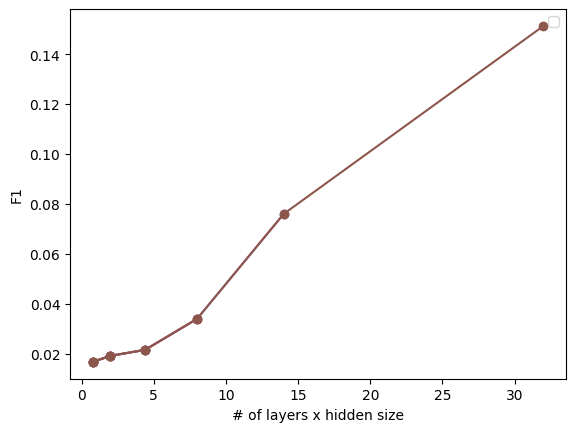

[1.43759167e-05 4.01395805e-03 9.06139752e-03]


In [46]:
x_vals = []
y_vals = []
for size in range(len(model_sizes)):
    x_vals.append(parameters[size])
    y_vals.append(Qwen_f1[size])
    plt.plot(x_vals, y_vals, marker="o")
plt.legend() 
plt.xlabel("# of layers x hidden size")
plt.ylabel("F1") 
plt.show()

p = np.polyfit(x_vals, y_vals, 2)
print(p)

/var/folders/4c/rx0z8dkn0d76h53p7048t57m0000gn/T/ipykernel_22945/609835081.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


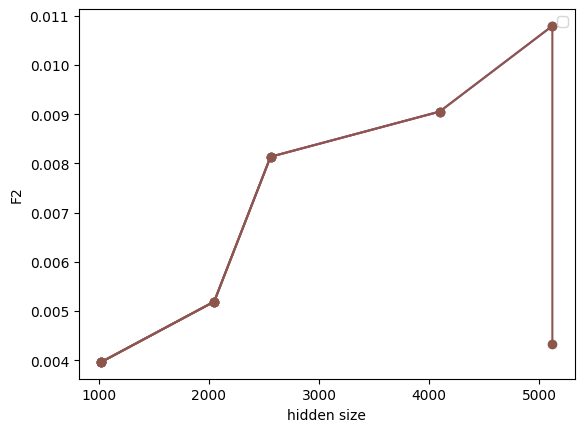

[-6.09629261e-10  4.76550490e-06 -7.18220283e-04]


In [37]:
x_vals = []
y_vals = []
for size in range(len(model_sizes)):
    x_vals.append(h[size])
    y_vals.append(Qwen_f2[size])
    plt.plot(x_vals, y_vals, marker="o")
plt.legend() 
plt.xlabel("hidden size")
plt.ylabel("F2") 
plt.show()

p = np.polyfit(x_vals, y_vals, 2)
print(p)